## Проект по анализу данных о фильмах и сериалах на Нетфликсе

* https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies

##### Довольно долго выбирал какие данные анализировать, лично мне по работе в данныый момент ничего анализировать не нужно, а данные с сайта ФТС (с проекта по парсингу+бота) казались скучными:) <br> Копаясь на Kaggle нашел вот такой датасет, который показался интересным поскольку достаточно объемный, и содержит данные разных типов.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 


In [2]:
df = pd.read_csv('titles.csv')

#### Посмотрим что содержится в датасете:

In [3]:
df.head(3)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300


#### Все выглядит понятным, но я все же переименую первую колонку из 'id' в 'netflix_id', а также отсортирую датасет по названию в алфавитном порядке:

In [4]:
df = df.sort_values('title')
df.rename(columns={'id' : 'netflix_id'}, inplace=True)

#### Последний раз проверим названия колонок и идем дальше:

In [5]:
df.columns

Index(['netflix_id', 'title', 'type', 'description', 'release_year',
       'age_certification', 'runtime', 'genres', 'production_countries',
       'seasons', 'imdb_id', 'imdb_score', 'imdb_votes', 'tmdb_popularity',
       'tmdb_score'],
      dtype='object')

##### Посмотрим общую статистику по таблице:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5850 entries, 2658 to 1704
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   netflix_id            5850 non-null   object 
 1   title                 5849 non-null   object 
 2   type                  5850 non-null   object 
 3   description           5832 non-null   object 
 4   release_year          5850 non-null   int64  
 5   age_certification     3231 non-null   object 
 6   runtime               5850 non-null   int64  
 7   genres                5850 non-null   object 
 8   production_countries  5850 non-null   object 
 9   seasons               2106 non-null   float64
 10  imdb_id               5447 non-null   object 
 11  imdb_score            5368 non-null   float64
 12  imdb_votes            5352 non-null   float64
 13  tmdb_popularity       5759 non-null   float64
 14  tmdb_score            5539 non-null   float64
dtypes: float64(5), int

### Посмотрим сводную статистику по текстовым колонкам, и введем исправления:

In [7]:
df.describe(include='object').transpose()

,count,unique,top,freq
netflix_id,5850,5850,ts265844,1
title,5849,5798,Connected,3
type,5850,2,MOVIE,3744
description,5832,5829,"Marta may be an orphan, and she may be affecte...",2
age_certification,3231,11,TV-MA,883
genres,5850,1726,['comedy'],484
production_countries,5850,452,['US'],1959
imdb_id,5447,5447,tt12635254,1


#### Колонки страны и жанра выглядят странно, проверим тип данных:

In [8]:
print(df.iloc[0][7])
print(type(df.iloc[0][7]))
print(df.iloc[0][8])
print(type(df.iloc[0][8]))

[]
<class 'str'>
[]
<class 'str'>


##### Несмотря на то что тип данных здесь "строка", визуально они отображаются как "список", из-за лишних квадратных скобок и кавычек, уберем эти лишние знаки:

In [9]:
df['genres'] = df['genres'].apply(lambda x: x.replace('[','').replace(']','').replace("'", ""))
df['production_countries'] = df['production_countries'].apply(lambda x: x.replace('[','').replace(']','').replace("'", ""))

#### В колонке age_certification используются рейтинги разных систем, многие из которых пересекаются:
- TV-MA = R (до 17 только с родителями)
- TV-14 = PG-13 (может содержать сцены неподходящие для детей до 13)
- TV-PG = PG (может содержать сцены неподходящие для маленьких детей)
- TV-G = G (подходит для любого возраста)
##### заменим все TV рейтинги на эквивалентные по P-PG системе:

In [10]:
df.loc[df['age_certification'] == 'TV-MA', 'age_certification'] = 'R'
df.loc[df['age_certification'] == 'TV-14', 'age_certification'] = 'PG-13'
df.loc[df['age_certification'] == 'TV-PG', 'age_certification'] = 'PG'
df.loc[df['age_certification'] == 'TV-G', 'age_certification'] = 'G'

##### Заменим пропуски данных о стране производства и жанре:

In [11]:
df.loc[df['production_countries'] == '', 'production_countries'] = 'unknown'
df.loc[df['genres'] == '', 'genres'] = 'unknown'

#### В дальнейшем мне понадобиться вытащить список уникальных жанров и стран производства. Метов .unique() не сработает, поскольку  'US, GB' будет считаться как отдельная уникальная страна, и жанр вроде 'thriller, horror' тоже будет учитываться целиком. Поэтому я написал  2 функции, первая для получения списка уникальных значений в колонках, вторая для подсчета частоты этих значений:

In [12]:
def get_unique(column):
    unique = []
    for cell in column:
        if ',' in cell:
            cell = cell.split(', ')
            for item in cell:
                if item not in unique:
                    unique.append(item)
        elif cell not in unique:
            unique.append(cell)
    return unique

In [13]:
def count_occurs(column, uniques):
    frequency = {column : uniques, 'frequency': []}
    for genre in uniques:
        frequency['frequency'].append(len(df[df[column].str.contains(pat = genre)]))
    return pd.DataFrame.from_dict(frequency).sort_values('frequency', ascending=False).reset_index(drop=True)

### Перейдем к числовым колонкам:

In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
release_year,5850.0,2016.417094,6.937726,1945.000000,2016.0000,2018.000,2020.0000,2022.000
runtime,5850.0,76.888889,39.002509,0.000000,44.0000,83.000,104.0000,240.000
seasons,2106.0,2.162868,2.689041,1.000000,1.0000,1.000,2.0000,42.000
imdb_score,5368.0,6.510861,1.163826,1.500000,5.8000,6.600,7.3000,9.600
imdb_votes,5352.0,23439.382474,95820.470909,5.000000,516.7500,2233.500,9494.0000,2294231.000
tmdb_popularity,5759.0,22.637925,81.680263,0.009442,2.7285,6.821,16.5900,2274.044
tmdb_score,5539.0,6.829175,1.170391,0.500000,6.1000,6.900,7.5375,10.000


#### Почти все хорошо, кроме минимального значения runtime, фильм или сериал не может идти 0 минут, посмотрим что это:


In [15]:
df.loc[df['runtime'] == 0]

,netflix_id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
5223,ts308511,Back to 15,SHOW,"Unhappy at work and in her personal life, Anit...",2022,PG-13,0,"drama, comedy",BR,1.0,tt15301854,6.6,662.0,5.829,6.3
2577,ts81856,Borges,SHOW,Four employees of an import company discover t...,2018,R,0,comedy,BR,2.0,tt7895652,6.2,172.0,1.415,7.8
5152,ts327074,Bullsh*t the Game Show,SHOW,"Throughout the game, players will work their w...",2022,PG-13,0,reality,US,1.0,tt16912298,6.1,750.0,1.125,7.2
3887,ts251783,Emily's Wonder Lab,SHOW,Science-loving host Emily Calandrelli makes ST...,2020,NaN,0,family,US,1.0,NaN,NaN,NaN,3.324,9.3
1340,ts56032,La Niña,SHOW,A young woman who was part of the guerrilla fo...,2016,R,0,"action, drama",CO,1.0,tt5677942,8.4,649.0,23.759,7.7
4394,ts224261,Nailed It! Germany,SHOW,Home cooks try -- and inevitably fail -- to re...,2020,PG-13,0,reality,DE,1.0,tt11460744,5.7,102.0,2.157,10.0
518,ts204466,Pecados capitales,SHOW,Evaristo Salinas is a successful businessman i...,2002,R,0,"romance, comedy, drama",CO,1.0,tt0355119,8.5,195.0,1.791,NaN
5515,ts331654,Pedal to Metal,SHOW,"After a race they drive in ends fatally, frien...",2022,R,0,"drama, action, thriller, crime",MX,1.0,tt18568732,7.7,59.0,5.668,6.6
594,ts188031,Pink Zone,SHOW,"Is the story of four friends: Natalia, Angélic...",2007,NaN,0,"drama, romance, comedy",MX,1.0,tt11194518,5.8,52.0,0.682,10.0
1430,ts87884,Sons of the Caliphate,SHOW,This is a drama series about the lives of thre...,2015,PG-13,0,drama,NG,1.0,tt10202268,7.4,33.0,1.347,NaN


#### Искать продолжительность в ручную в гугле у такого количества тайтлов нет никакого желания, так что просто проставим np.nan вместо нулей, чтобы избежать влияния нулей на подсчет статистики (средних и тд)

In [16]:
df.loc[df['runtime'] == 0, 'runtime'] = np.nan

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
release_year,5850.0,2016.417094,6.937726,1945.000000,2016.0000,2018.000,2020.0000,2022.000
runtime,5836.0,77.073338,38.866785,2.000000,44.0000,83.000,105.0000,240.000
seasons,2106.0,2.162868,2.689041,1.000000,1.0000,1.000,2.0000,42.000
imdb_score,5368.0,6.510861,1.163826,1.500000,5.8000,6.600,7.3000,9.600
imdb_votes,5352.0,23439.382474,95820.470909,5.000000,516.7500,2233.500,9494.0000,2294231.000
tmdb_popularity,5759.0,22.637925,81.680263,0.009442,2.7285,6.821,16.5900,2274.044
tmdb_score,5539.0,6.829175,1.170391,0.500000,6.1000,6.900,7.5375,10.000


#### Готово, в данных все еще есть некоторые пропуски, например у некоторых тайтлов отсутствует информация о рейтинге / популярности, но в этом случае я просто буду считать их "непопулярными (0 отзывов), и не учитывать в подсчетах связанных с рейтингом
***

### Перейдем к вводу дополнительных колонок - признаков и первичному анализу/визуализации данных

#### 1 - введем колонку с признаком "является ли сериал/фильм: американским, или США принимали участие в создании, или США не принимали участия в создании ", и посмотрим на распределение (просто используя value_counts, не думаю что есть смысл строитьграфик с 2 показателями:) )

In [18]:
# Поскольку в ячейке страны производства может упоминаться больше 1 страны, я не могу просто использовать .value_counts(),
# так как тогда "US, GB" посчитается как отдельная страна производства. .str.contains(pat
us_bool = df['production_countries'].str.contains(pat= 'US')
df['american'] = np.where(us_bool, 'American', 'No')
us_participated_bool = df['production_countries'] == 'US'
df['american'] = np.where(us_participated_bool, 'US participated', 'US not involved')
df['american'].value_counts()

US not involved    3891
US participated    1959
Name: american, dtype: int64

In [19]:
country_conditions = [
    (df['production_countries'] == 'US'),
    (df['production_countries'].str.contains(pat= 'US')),
    (~df['production_countries'].str.contains(pat= 'US'))
     ]

country_result = ['American', 'US participated', 'US not involved']

df['american'] = np.select(country_conditions, country_result)

#### Лично я ожидал что ситуация будет обратная, и США будет упоминаться как страна производства у 2/3 тайтлов.
___

#### Введем еще 1 дополнительный признак, наличие у фильма/сериала рейтинга у IMDB, TBDB, или обоих:

In [20]:
score_conditions = [
    (df['imdb_score'].isnull()) & (df['tmdb_score'].isnull()),
    (df['imdb_score'].notnull()) & (df['tmdb_score'].isnull()),
    (df['imdb_score'].isnull()) & (df['tmdb_score'].notnull()),
    (df['imdb_score'].notnull()) & (df['tmdb_score'].notnull())
    ]

score_result = ['No Ratings', 'IMDB only', 'TMDB only', 'Both']

df['ratings'] = np.select(score_conditions, score_result)

##### Посмотрим на распределение признака:

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Both'),
  Text(1, 0, 'TMDB only'),
  Text(2, 0, 'IMDB only'),
  Text(3, 0, 'No Ratings')])

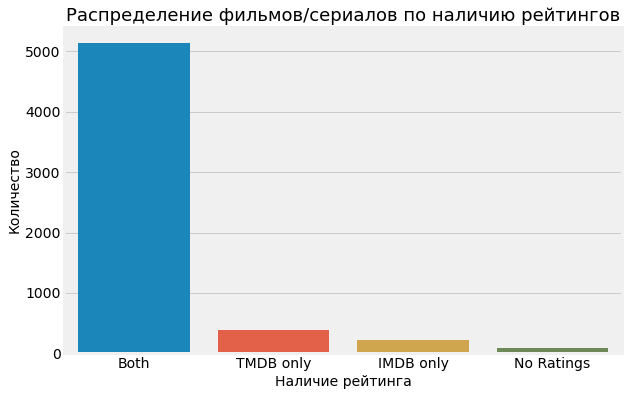

In [21]:
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')
popularity_plot = sns.countplot(x=df['ratings'], order = df['ratings'].value_counts().index)
plt.xlabel("Наличие рейтинга", size=14)
plt.ylabel("Количество", size=14)
plt.title("Распределение фильмов/сериалов по наличию рейтингов", size=18)
plt.xticks(rotation=0)

##### Вероятно этого можно было ожидать, зачем Нетфлиску покупать для показа неизвестные тайтлы.
___

#### И последний доп признак, известность фильма/сериала, расчитывать будем по количеству отзывов на любой из платформ (IMDB/TMDB):
- Very Popular: если количество отзывов 75-100% от максимального
- Popular: количество отзывов 50-75% от максимального
- Unpopular: количество отзывов 25-50% от максимального
- Unknown: количество отзывов 0-25% от максимального

In [22]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
release_year,5850.0,2016.417094,6.937726,1945.000000,2016.0000,2018.000,2020.0000,2022.000
runtime,5836.0,77.073338,38.866785,2.000000,44.0000,83.000,105.0000,240.000
seasons,2106.0,2.162868,2.689041,1.000000,1.0000,1.000,2.0000,42.000
imdb_score,5368.0,6.510861,1.163826,1.500000,5.8000,6.600,7.3000,9.600
imdb_votes,5352.0,23439.382474,95820.470909,5.000000,516.7500,2233.500,9494.0000,2294231.000
tmdb_popularity,5759.0,22.637925,81.680263,0.009442,2.7285,6.821,16.5900,2274.044
tmdb_score,5539.0,6.829175,1.170391,0.500000,6.1000,6.900,7.5375,10.000


In [23]:
# Этот фрагмент кода мне до сих пор кажется странным, но он работает (вроде как :D).
# Изначально он выглядел именно так как сейчас, но мне он казался неправильным,
# ведь второе условие (кол-во рейтингов >= 0.5 квантиль) пересекается с первым (>= 0.75 quantile) и тд.,
# я попытался расписать условия подробнее, в виде 0.75 > x >= 0.50:

# (df['imdb_votes'].quantile(q=0.75) > df['imdb_votes'] >= df['imdb_votes'].quantile(q=0.50))

# но такая запись была во первых трудно читаемой, а во вторых выавала ошибку, расписывать это как (0.75 > x) & (x >= 0.50):

# ((df['imdb_votes'].quantile(q=0.75) > df['imdb_votes']) & (df['imdb_votes'] >= df['imdb_votes'].quantile(q=0.50))

# мне не хотелось, поскольку это только часть условия по imdb, в строку пришлось бы вписывать такую же дичь для tmdb.
# В итоге я решил посмотреть, насколько корректно проставятся рейтинги, не будет ли 'Unpopular' поставлен туда
# где должен быть 'Very popular', и оказалось все корректно в ячейке ниже через одну будет проверка.

popularity_conditions = [
    (df['imdb_votes'] >= df['imdb_votes'].quantile(q=0.75)) | (df['tmdb_popularity'] >= df['tmdb_popularity'].quantile(q=0.75)),
    (df['imdb_votes'] >= df['imdb_votes'].quantile(q=0.50)) | (df['tmdb_popularity'] >= df['tmdb_popularity'].quantile(q=0.50)),
    (df['imdb_votes'] >= df['imdb_votes'].quantile(q=0.25)) | (df['tmdb_popularity'] >= df['tmdb_popularity'].quantile(q=0.25)),
    (df['imdb_votes'] >= df['imdb_votes'].min()) | (df['tmdb_popularity'] >= df['tmdb_popularity'].min())
]

popularity_result = ['Very Popular', 'Popular', 'Unpopular', 'Unknown']

In [24]:
df['popularity'] = np.select(popularity_conditions, popularity_result)

In [25]:
# Проверка распределений категорий популярности, видим что у тайтлов где хотя бы по 1 из сайтов количество
# отзывов больше чем у 75%, проставлена только категория 'Very Popular'. Можно поиграться со значением q и увидеть,
# что в выборку начинают попадать другие категории, при этом максимальное количество категории 'Very Popular' не меняется.
q = 0.49
df.loc[(df['imdb_votes'] >= df['imdb_votes'].quantile(q)) | (df['tmdb_popularity'] >= df['tmdb_popularity'].quantile(q))]['popularity'].value_counts()

Very Popular    2005
Popular         1520
Unpopular         49
Name: popularity, dtype: int64

##### Видим что у тайтлов где нет ни 1 голоса на IMDB, ни данных о популярности на TMDB, в категори популярности проставились нули, на всякий случай проверим это посмотрев на df.loc[df['popularity'] == '0'], после чего просто проставим там Unknown

In [26]:
df.loc[df['popularity'] == '0']

,netflix_id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,american,ratings,popularity
5844,tm1074617,Bling Empire - The Afterparty,MOVIE,"The stars of ""Bling Empire"" discuss the show's...",2021,NaN,35.0,unknown,US,NaN,NaN,NaN,NaN,NaN,NaN,American,No Ratings,0
5507,tm1074621,Bridgerton - The Afterparty,MOVIE,"""Bridgerton"" cast members share behind-the-sce...",2021,NaN,38.0,unknown,US,NaN,NaN,NaN,NaN,NaN,NaN,American,No Ratings,0
627,tm1077037,Chhota Bheem & Krishna: Pataliputra- City of t...,MOVIE,Krishna needs Bheem's help: The ruined city of...,2010,G,65.0,animation,IN,NaN,tt6543110,NaN,NaN,NaN,NaN,US not involved,No Ratings,0
808,tm1077038,Chhota Bheem: Journey to Petra,MOVIE,"The king has been away to meet an old friend, ...",2011,G,67.0,animation,IN,NaN,tt6543194,NaN,NaN,NaN,NaN,US not involved,No Ratings,0
2754,ts106612,Chicken Soup for the Soul's Being Dad,SHOW,NaN,2018,PG,40.0,reality,unknown,1.0,tt8908110,NaN,NaN,NaN,NaN,US not involved,No Ratings,0
1588,tm526163,Dinosaur World,MOVIE,Scientist Khojwala finds it difficult to nurtu...,2015,NaN,65.0,"animation, comedy, drama",IN,NaN,tt2797146,NaN,NaN,NaN,NaN,US not involved,No Ratings,0
4648,tm1113921,In Vitro,MOVIE,'In Vitro' is an otherworldly rumination on me...,2019,NaN,27.0,unknown,unknown,NaN,tt10545994,7.7,NaN,NaN,NaN,US not involved,IMDB only,0
1668,tm1223831,Motu Patlu Aur Khazaane Ki Race,MOVIE,Motu and Patlu rescue a dog from a group of ev...,2015,NaN,75.0,"animation, action, comedy",unknown,NaN,tt20765946,NaN,NaN,NaN,NaN,US not involved,No Ratings,0
2930,tm1223999,Motu Patlu in Dragon World,MOVIE,Motu and friends go for an adventure filled jo...,2017,NaN,78.0,"comedy, animation",unknown,NaN,tt20783648,NaN,NaN,NaN,NaN,US not involved,No Ratings,0
1088,tm1223427,Motu Patlu in Wonderland,MOVIE,Motu and Patlu take a ride in their scientist ...,2013,NaN,75.0,animation,unknown,NaN,tt20602440,NaN,NaN,NaN,NaN,US not involved,No Ratings,0


In [27]:
df.loc[df['popularity'] == '0', 'popularity'] = 'Unknown'

#### Посмотрим на то, как распредлились категории популярности у тайтлов:

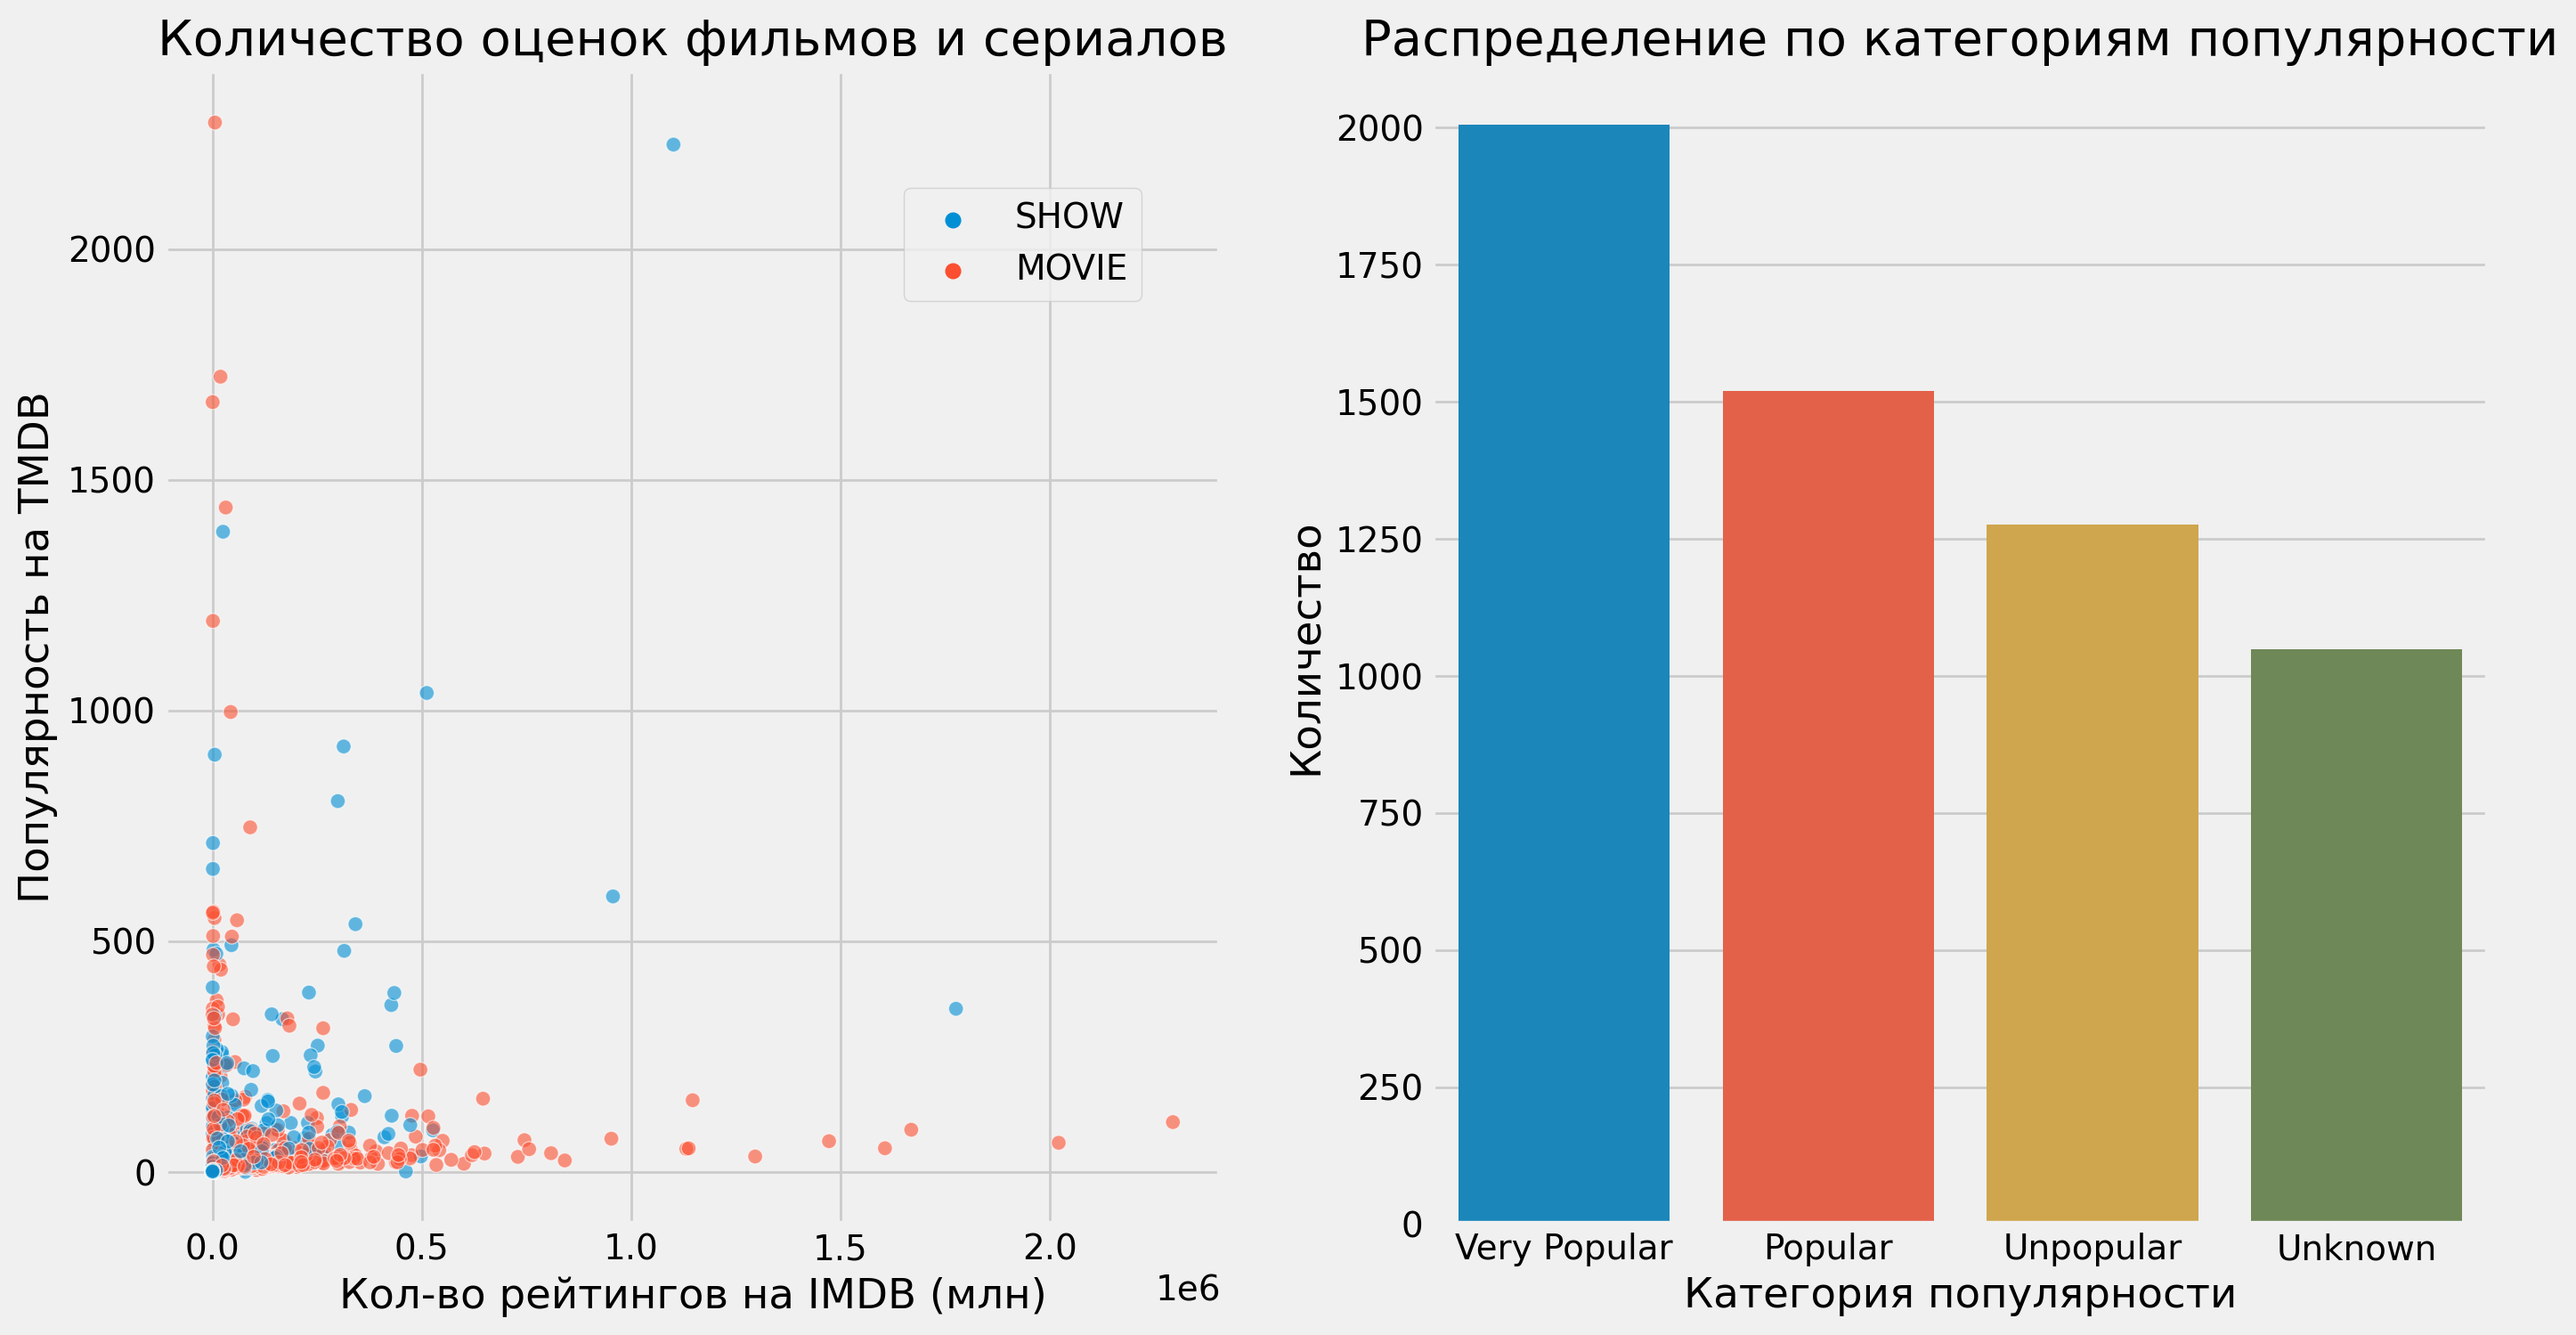

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15,8), dpi=200)
plt.style.use('fivethirtyeight')

popularity = sns.countplot(x=df['popularity'], order = df['popularity'].value_counts().index)
popularity.set(xlabel="Категория популярности", 
               ylabel="Количество", 
               title="Распределение по категориям популярности");

#plt.xlabel("Категория популярности", size=20)
#plt.ylabel("Количество", size=20)
#plt.title("Распределение фильмов/сериалов по категориям популярности", size=18)
#plt.figure(figsize=(8,6),dpi=500)

vote_count_plot = sns.scatterplot(data=df,x='imdb_votes',y='tmdb_popularity',hue='type',alpha=0.6, ax=ax[0])
vote_count_plot.set(xlabel="Кол-во рейтингов на IMDB (млн)", 
                    ylabel="Популярность на TMDB", 
                    title="Количество оценок фильмов и сериалов");
vote_count_plot.legend(loc=(0.7,0.8))
#plt.xlabel("Кол-во рейтингов на IMDB", size=10)
#plt.ylabel("Популярность на TMDB", size=10)
#plt.title("Распределение рейтингов фильмов и сериалов", size=12)


#### На первый взгляд правый график может показаться неправдоподобным, ведь мы распределили категории по квантилям, значит частота категорий должна быть равна? Но распределение было сделано по квантилям 2 колонок, данные в которых распределяются неравномерно. На левом графике видно, что тайтлы очень редко имеют равный персентиль отзывов/популярности по IMDB/TMDB. Для того чтобы попасть в категорию "Unknown" у тайтла должно быть мало отзывов как у IMDB, так и у TMDB, таких тайтлов не много, большинство имеют достаточное количество отзывов для более высоких категорий хотя бы на одной из прощадок.
___

#### Теперь глянем как распределились тайтлы по категориям возрастных ограничений:

Text(0.5, 1.0, 'Распределение фильмов/сериалов по возрастным ограничениям')

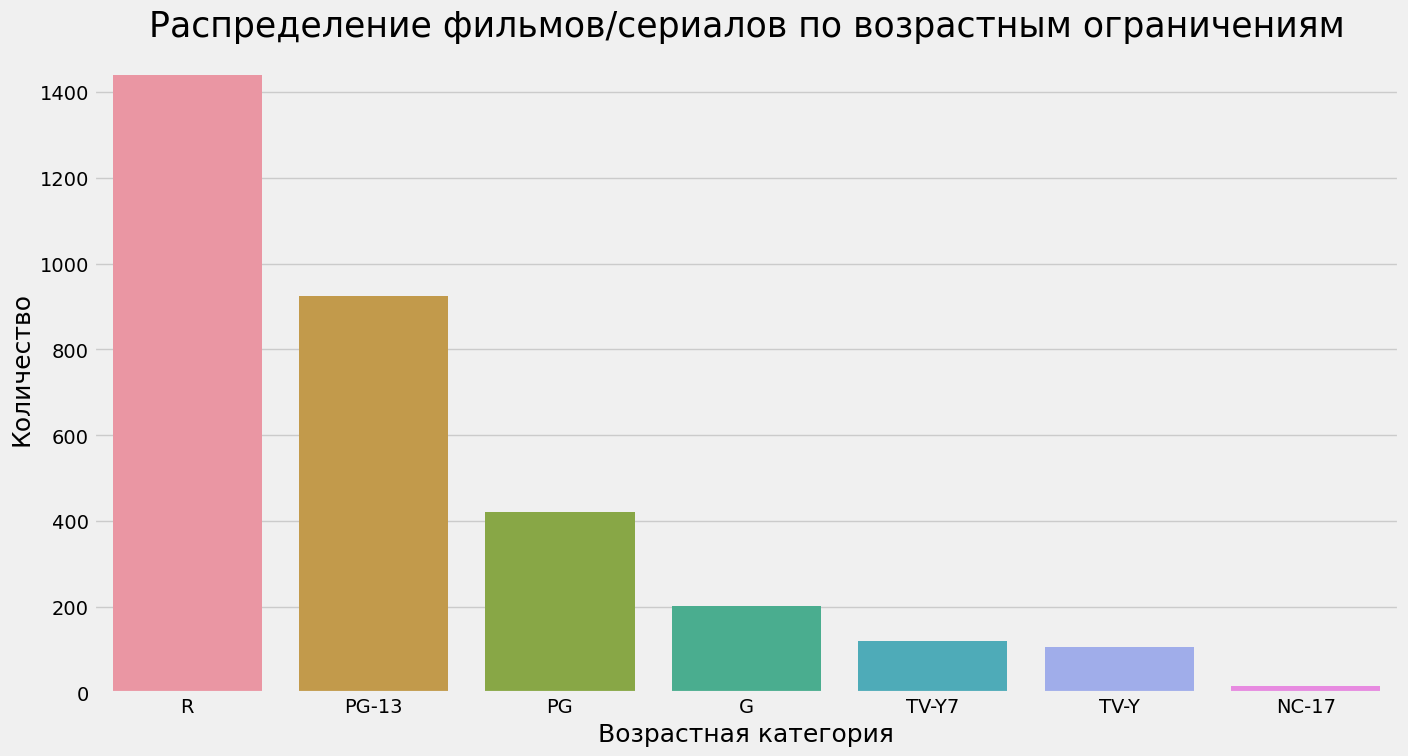

In [29]:
plt.figure(figsize=(15,8), dpi=100)
age_restrictions = sns.countplot(x=df['age_certification'], order = df['age_certification'].value_counts().index)

age_restrictions.set_xlabel("Возрастная категория", size=18)
age_restrictions.set_ylabel("Количество", size=18)
age_restrictions.set_title("Распределение фильмов/сериалов по возрастным ограничениям", size=25)



#### Видим что наиболее распространены фильмы/сериалы категорий R (детям до 17 в сопровождении родителей, и PG-13 (до 13 с родителями), также видим маленькое количество фильмов категории NC-17 (adults only), очень любопытно, ни разу не встречал контента который я бы назвал adults only на Нетфликсе :D, посмотрим что это, и в каких жанрах :

In [30]:
adults_only = df.loc[df['age_certification'] == 'NC-17']
adults_only

,netflix_id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,american,ratings,popularity
4887,tm1191224,365 Days: This Day,MOVIE,Laura and Massimo are back and hotter than eve...,2022,NC-17,111.0,"romance, drama",PL,NaN,tt12996154,2.5,16587.0,449.292,5.8,US not involved,Both,Very Popular
583,tm49865,Aamir,MOVIE,A doctor of Indian origin returning to Mumbai ...,2008,NC-17,96.0,"thriller, crime, drama, action",IN,NaN,tt1241195,7.6,11290.0,4.053,6.9,US not involved,Both,Very Popular
682,tm60844,Berserk: The Golden Age Arc I - The Egg of the...,MOVIE,"Guts, an immensely strong sword-for-hire, has ...",2012,NC-17,76.0,"action, fantasy, animation, horror, war, drama",JP,NaN,tt2210479,7.5,12548.0,20.928,7.4,US not involved,Both,Very Popular
956,tm167944,Berserk: The Golden Age Arc III - The Advent,MOVIE,A year has passed since Guts parted ways with ...,2013,NC-17,110.0,"drama, fantasy, animation, action, romance, ho...",JP,NaN,tt2358913,7.8,10173.0,41.099,7.6,US not involved,Both,Very Popular
198,tm7135,Bill Hicks: One Night Stand,MOVIE,"Bill Hicks shows us his view on smoking, smoki...",1991,NC-17,30.0,comedy,US,NaN,NaN,NaN,NaN,1.080,7.5,American,TMDB only,Unknown
3420,tm933375,Cuties,MOVIE,"Amy, an 11-year-old girl, joins a group of dan...",2020,NC-17,96.0,"drama, european",FR,NaN,tt9196192,3.4,30338.0,10.271,5.3,US not involved,Both,Very Popular
1948,tm217228,Death Note,MOVIE,A young man comes to possess a supernatural no...,2017,NC-17,101.0,"horror, thriller, crime, fantasy, drama, action",US,NaN,tt1241317,4.5,84119.0,22.306,4.2,American,Both,Very Popular
3577,tm922532,Freaks – You're One of Us,MOVIE,After having a chance encounter with a mysteri...,2020,NC-17,93.0,"fantasy, thriller, drama, action, scifi",DE,NaN,tt12875782,5.4,5809.0,11.865,5.7,US not involved,Both,Popular
1203,tm245271,Gantz:O,MOVIE,"Somewhere in Tokyo, there is a room. In that r...",2016,NC-17,95.0,"scifi, action, animation, fantasy, thriller, h...",JP,NaN,tt5923962,7.1,14950.0,28.818,7.3,US not involved,Both,Very Popular
789,tm164090,Lavell Crawford: Can a Brother Get Some Love?,MOVIE,"""Last Comic Standing"" runner-up Lavell Crawfor...",2011,NC-17,90.0,"comedy, documentation",US,NaN,tt2084872,6.9,234.0,2.301,6.5,American,Both,Unknown


In [31]:
unique_genres = get_unique(df['genres'])
adult_genres_frequency = {'genres' : unique_genres, 'frequency' : []}
for genre in unique_genres:
    adult_genres_frequency['frequency'].append(len(adults_only[adults_only['genres'].str.contains(pat = genre)]))
    
adult_genres_df = pd.DataFrame.from_dict(adult_genres_frequency).sort_values('frequency', ascending=False).reset_index(drop=True)
adult_genres_data = adult_genres_df[(adult_genres_df != 0).all(1)]

Text(0.5, 1.0, 'Распределение жанров в фильмах/сериалах категории Adults Only')

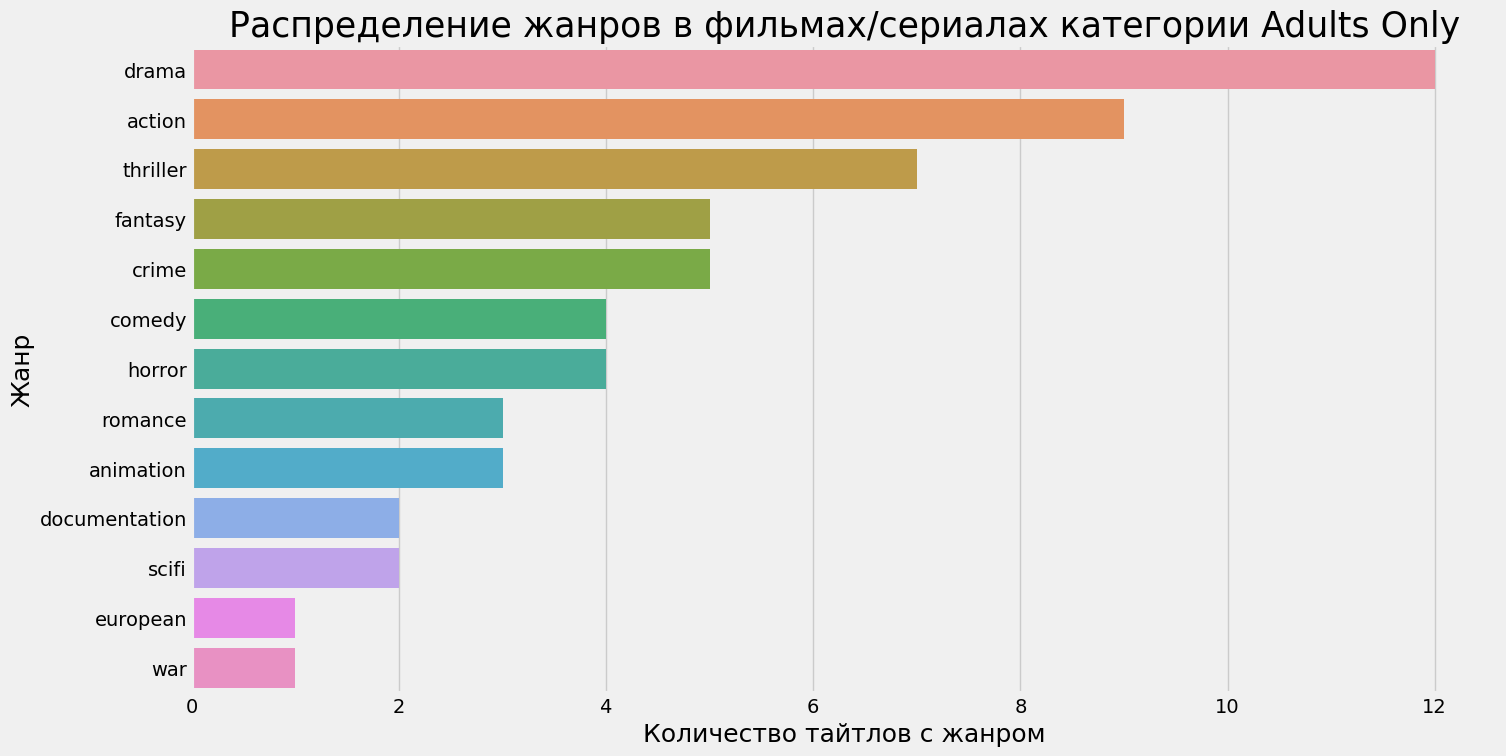

In [32]:
plt.figure(figsize=(15,8), dpi=100)
adult_genres = sns.barplot(x=adult_genres_data['frequency'], y=adult_genres_data['genres'])

adult_genres.set_xlabel("Количество тайтлов с жанром", size=18)
adult_genres.set_ylabel("Жанр", size=18)
adult_genres.set_title("Распределение жанров в фильмах/сериалах категории Adults Only", size=25)

#### Эх, драмы, экшены, триллеры, и никаких вестернов, музыкальных или семейных фильмов для взрослых.
___

#### Составим список уникальных жанров и таблицу с частотой жанров:

In [33]:
genres_df = count_occurs('genres', unique_genres)

Text(0.5, 1.0, 'Распределение жанров в фильмах/сериалах')

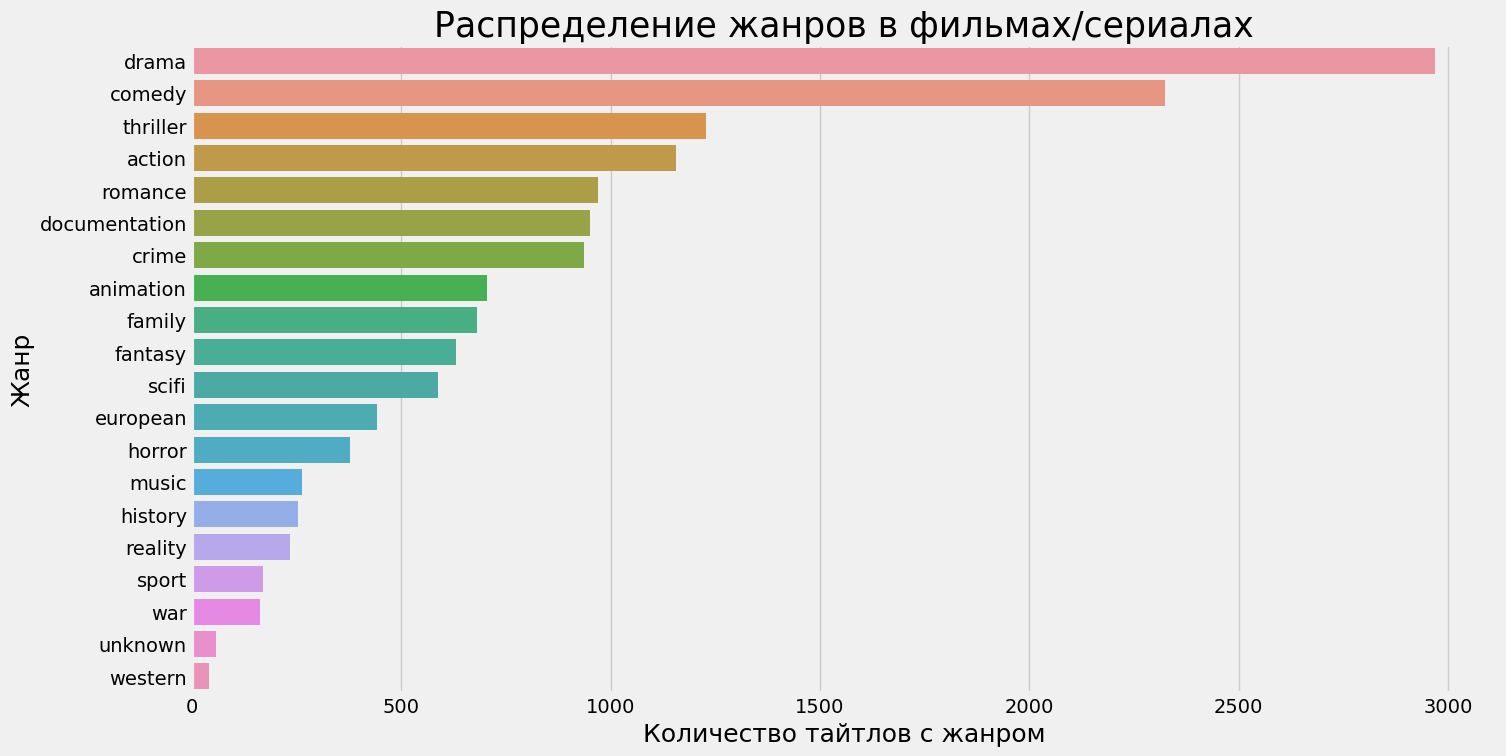

In [34]:
plt.figure(figsize=(15,8), dpi=100)
genres_plot = sns.barplot(x=genres_df['frequency'], y=genres_df['genres'])

genres_plot.set_xlabel("Количество тайтлов с жанром", size=18)
genres_plot.set_ylabel("Жанр", size=18)
genres_plot.set_title("Распределение жанров в фильмах/сериалах", size=25)

#### Самое заметное отличие общего распределения жанров от распределения в категории "только для взрослых" - в последнем гораздо менее распространены фильмы/сериалы с жанром "комедия" и "romance". 
___

In [35]:
unique_countries = get_unique(df['production_countries'])
countries_df = count_occurs('production_countries', unique_countries)

Text(0.5, 1.0, 'Топ 30 стран по участию в создании фильмов/сериалов')

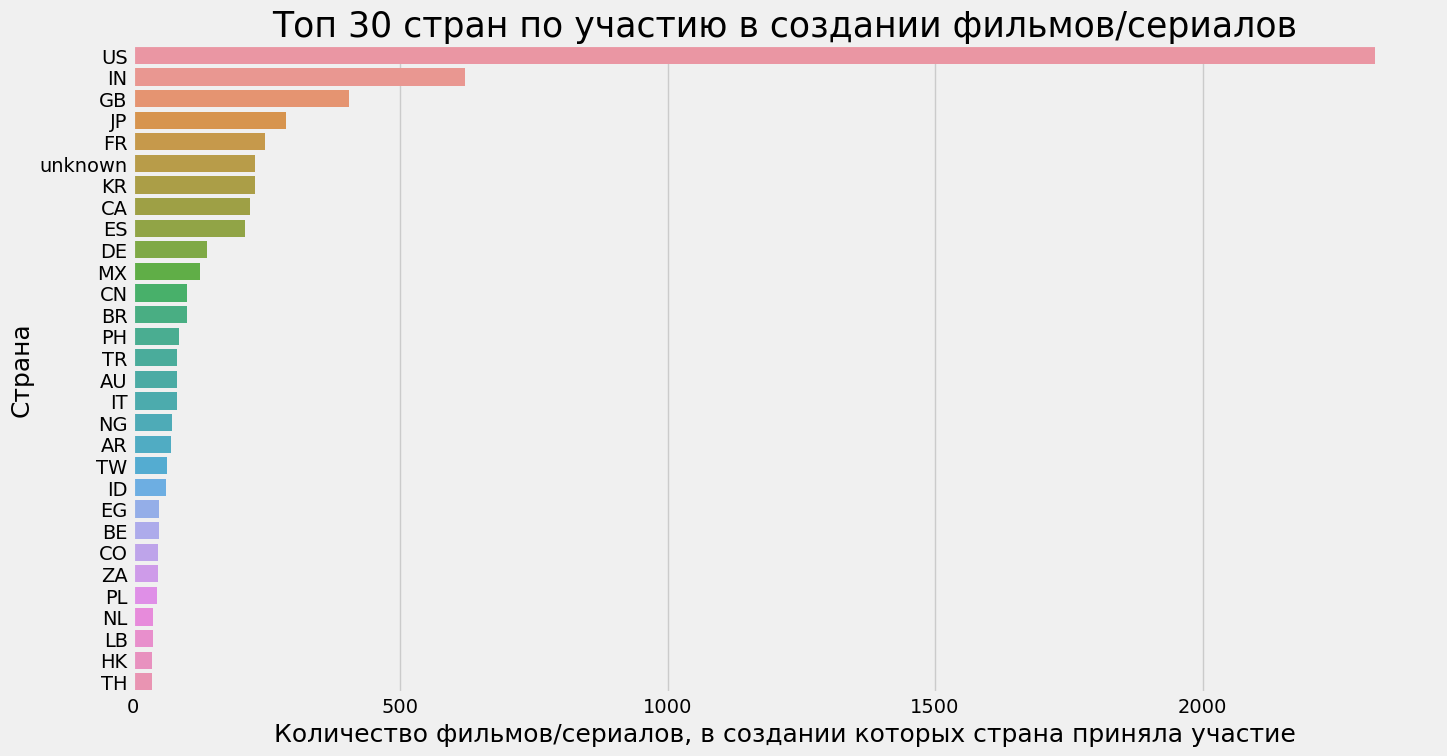

In [36]:
plt.figure(figsize=(15,8), dpi=100)
countries_plot = sns.barplot(x=countries_df['frequency'].head(30), y=countries_df['production_countries'].head(30))

countries_plot.set_xlabel("Количество фильмов/сериалов, в создании которых страна приняла участие", size=18)
countries_plot.set_ylabel("Страна", size=18)
countries_plot.set_title("Топ 30 стран по участию в создании фильмов/сериалов", size=25)

#### Вполне ожидаемое первое место у США, но неожиданное лично для меня второе место у Индии, посколько мне в подборках ни разу не попадались индийские сериалы.
___

## Приступим к EDA, найдем ответы на следующие вопросы:
- Влияет ли участие США в создании фильма/сериала на его рейтинг/популярность?
- Как распределяется участие стран в создании фильмов/сериалов различных жанров?
- Существуют ли другие зависимости (матрица корреляций)

In [37]:
us_group = df.groupby('american')

#### Посмотрим общую статистику по группе:

In [38]:
us_group.describe().transpose()

american                   American  US not involved  US participated
release_year    count  1.959000e+03      3527.000000     3.640000e+02
                mean   2.015979e+03      2016.788772     2.015176e+03
                std    7.361701e+00         6.565859     7.781228e+00
                min    1.945000e+03      1954.000000     1.961000e+03
                25%    2.016000e+03      2016.000000     2.014000e+03
                50%    2.018000e+03      2019.000000     2.018000e+03
                75%    2.020000e+03      2020.000000     2.020000e+03
                max    2.022000e+03      2022.000000     2.022000e+03
runtime         count  1.956000e+03      3516.000000     3.640000e+02
                mean   6.689213e+01        81.240899     9.152747e+01
                std    3.445858e+01        40.474156     3.299398e+01
                min    2.000000e+00         2.000000     6.000000e+00
                25%    3.700000e+01        46.000000     8.275000e+01
                50%    6.300000e+01        88.000000     9.700000e+01
                75%    9.500000e+01       110.000000     1.110000e+02
                max    2.250000e+02       240.000000     2.080000e+02
seasons         count  7.750000e+02      1282.000000     4.900000e+01
                mean   2.652903e+00         1.835413     2.979592e+00
                std    3.452077e+00         2.019088     2.954444e+00
                min    1.000000e+00         1.000000     1.000000e+00
                25%    1.000000e+00         1.000000     1.000000e+00
                50%    2.000000e+00         1.000000     2.000000e+00
                75%    3.000000e+00         2.000000     4.000000e+00
                max    4.200000e+01        32.000000     1.600000e+01
imdb_score      count  1.822000e+03      3205.000000     3.410000e+02
                mean   6.548299e+00         6.496287     6.447801e+00
                std    1.115403e+00         1.201264     1.051513e+00
                min    2.000000e+00         1.500000     2.600000e+00
                25%    5.800000e+00         5.800000     5.800000e+00
                50%    6.600000e+00         6.600000     6.500000e+00
                75%    7.400000e+00         7.300000     7.200000e+00
                max    9.500000e+00         9.600000     8.800000e+00
imdb_votes      count  1.815000e+03      3198.000000     3.390000e+02
                mean   4.143023e+04      7854.655097     7.413725e+04
                std    1.331359e+05     30058.328940     1.872650e+05
                min    5.000000e+00         5.000000     8.000000e+00
                25%    9.990000e+02       340.250000     1.978000e+03
                50%    4.341000e+03      1400.000000     1.337000e+04
                75%    2.423300e+04      4774.500000     5.868100e+04
                max    2.021343e+06    534486.000000     2.294231e+06
tmdb_popularity count  1.950000e+03      3446.000000     3.630000e+02
                mean   2.814140e+01        18.930581     2.826807e+01
                std    9.987368e+01        72.288483     4.858354e+01
                min    9.441746e-03         0.600000     6.000000e-01
                25%    3.829000e+00         2.224250     6.808500e+00
                50%    8.962500e+00         5.111000     1.479500e+01
                75%    2.013550e+01        12.733250     2.983650e+01
                max    2.226231e+03      2274.044000     5.102680e+02
tmdb_score      count  1.924000e+03      3259.000000     3.560000e+02
                mean   6.871877e+00         6.820137     6.681126e+00
                std    1.037954e+00         1.263734     9.186929e-01
                min    1.500000e+00         0.500000     3.000000e+00
                25%    6.200000e+00         6.100000     6.000000e+00
                50%    6.900000e+00         6.900000     6.700000e+00
                75%    7.500000e+00         7.600000     7.304000e+00
                max    1.000000e+01        10.000000     1.000000e+01

#### Посмотрим отличаются ли медианные оценки между категориями:

In [39]:
df.groupby('american')[['imdb_score', 'tmdb_score']].mean()

,imdb_score,tmdb_score
american,,
American,6.548299,6.871877
US not involved,6.496287,6.820137
US participated,6.447801,6.681126


#### Видим что оценка почти не зависит от участия США в съемках, а как на счет популярности?

In [40]:
df.groupby('american')[['imdb_votes', 'tmdb_popularity']].mean()

,imdb_votes,tmdb_popularity
american,,
American,41430.225895,28.141396
US not involved,7854.655097,18.930581
US participated,74137.250737,28.268069


#### А вот тут уже четко прослеживается зависимость, тайтлы в создании которых США не участвовали гораздо менее известны. </br> Вывод: от участия США в создании зависит известность/популярность сериала, но не его рейтинг.
___

####  Теперь посмотрим какие страны чаще снимают фильмы/сериалы каких жанров. <br>Ниже сделана сводная таблица, показывающая в создании тайтлов каких жанров принимали участие какие страны:

In [41]:
df_country_genres = countries_df.copy()
df_country_genres[unique_genres] = 0
df_country_genres.set_index('production_countries', inplace=True)
df_country_genres.drop(['frequency'], axis=1, inplace=True)

In [42]:
for genre in unique_genres:
    for country in unique_countries:
        df_country_genres.loc[country, genre] = len(df[(df['genres'].str.contains(pat = genre)) & (df['production_countries'].str.contains(pat = country))])

In [43]:
df_country_genres_plot = (100 * df_country_genres / df_country_genres.sum())

In [44]:
df_country_genres_plot.head()

,unknown,horror,thriller,action,drama,history,documentation,romance,comedy,reality,fantasy,european,family,war,crime,sport,scifi,animation,music,western
production_countries,,,,,,,,,,,,,,,,,,,,
US,26.984127,40.133038,29.568106,32.137733,25.504691,30.357143,52.258065,21.584699,37.903861,54.356846,34.959350,14.449213,43.586550,28.017241,30.558097,42.553191,40.088757,35.906863,45.674740,58.928571
IN,1.587302,5.986696,12.425249,12.051650,13.534262,5.059524,1.751152,18.214936,10.165485,1.244813,4.065041,1.859800,4.483188,2.586207,13.815188,12.765957,1.331361,2.941176,4.152249,1.785714
GB,0.000000,4.878049,7.109635,4.949785,4.918965,13.690476,8.940092,3.642987,5.161545,6.639004,6.368564,11.587983,6.475716,15.086207,6.953339,5.851064,5.325444,5.514706,6.574394,7.142857
JP,4.761905,5.543237,3.654485,11.764706,4.805232,1.785714,1.013825,4.371585,3.743105,4.564315,15.176152,0.286123,4.732254,4.741379,2.378774,4.255319,16.863905,22.426471,4.844291,7.142857
FR,1.587302,3.325942,4.252492,3.299857,4.037532,5.357143,2.949309,3.096539,3.112687,1.659751,3.929539,16.165951,3.611457,5.172414,4.940531,2.659574,2.514793,4.289216,3.460208,3.571429


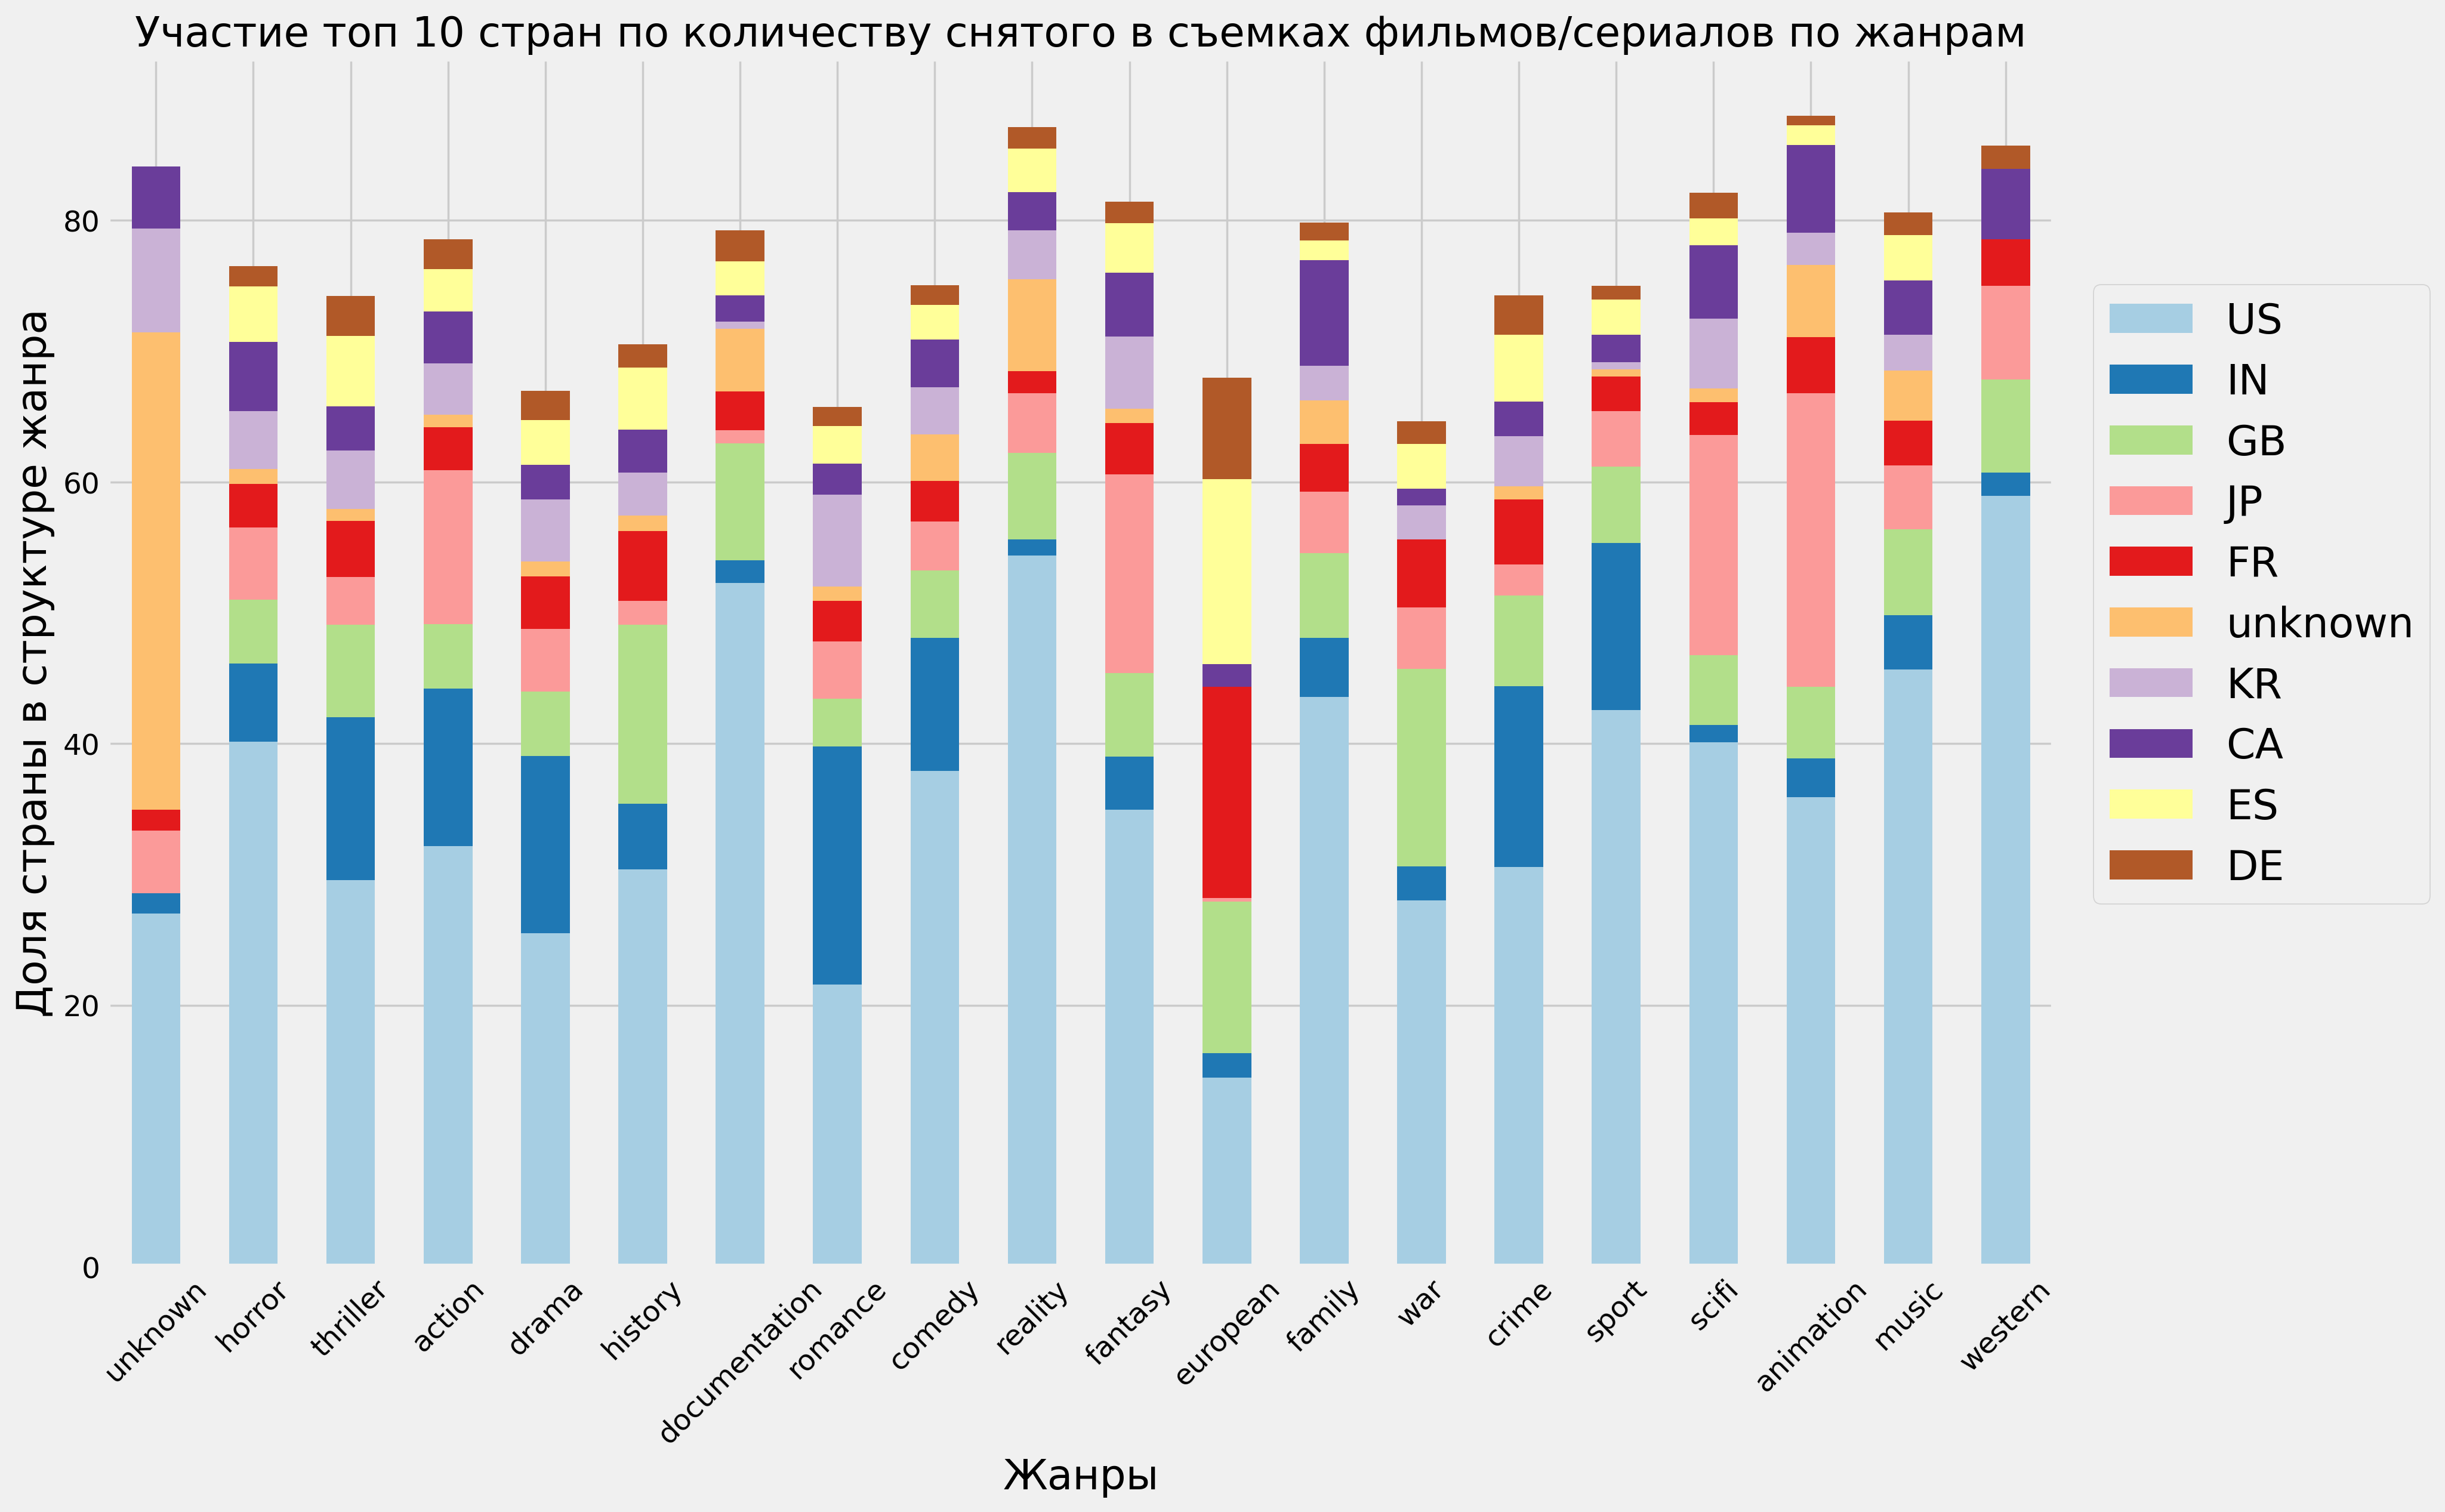

In [45]:
plt.rcParams["figure.dpi"] = 250
df_country_genres_plot.head(10).transpose().plot(kind='bar', stacked=True, figsize=(15,10), rot=45, colormap='Paired')
plt.style.use('fivethirtyeight')

plt.xlabel("Жанры", size=20)
plt.ylabel("Доля страны в структуре жанра", size=20)
plt.title("Участие топ 10 стран по количеству снятого в съемках фильмов/сериалов по жанрам", size=20)
plt.legend(loc=(1.02, 0.3), prop={'size': 20})


#### Выводы:
1) США участвуют в создании подавляющего большинства фильмов/сериалов во всех жанрах, кроме "европейского кино".<br>
2) Индия снимает почти столько же произведений в жанре "романтика" сколько и США, а вот "Научной фатастики" там производится мало.<br>
3) В Японии, больше всего производятся фильмы/сериалы жанров "sfi-fi", "анимационные", "фэнтези". <br>
____

In [46]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

#### Построим общую корреляционную матрицу:

Text(0.5, 1.0, 'Корреляционная Матрица')

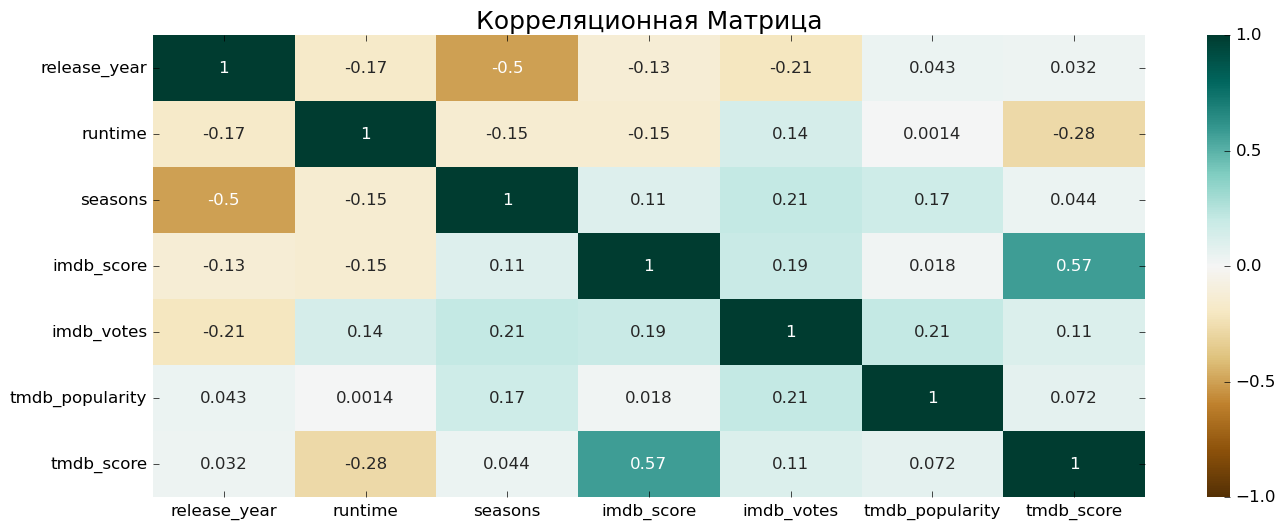

In [91]:
plt.rcdefaults()
plt.figure(figsize=(16, 6))
plt.style.use('classic')
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Корреляционная Матрица', fontdict={'fontsize':18})

#### Видим что в нашем датасете мало корреляций:
1) Рейтинг на IMDB коррелирует с рейтингом на TMDB.<br>
2) Количество сезонов отрицательно коррелирует с годом выпуска (ианьше сериалов снимали меньше/короче)<br>
3) Популярность на TMDB имеет слабую положительную корреляцию с годом выпуска, чем новее тем популярнее, а на IMDB, ситуация обратная, да, корреляция там всего 0.21, но она отрицательная. <br>

In [52]:
df.head()

,netflix_id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,american,ratings,popularity
2658,ts265844,#ABtalks,SHOW,#ABtalks is a YouTube interview show hosted by...,2018,PG,68.0,unknown,unknown,1.0,tt12635254,9.6,7.0,NaN,NaN,US not involved,IMDB only,Unknown
3237,tm820190,#Alive,MOVIE,"As a grisly virus rampages a city, a lone man ...",2020,NaN,98.0,"horror, thriller, action, drama",KR,NaN,tt10620868,6.3,38313.0,58.967,7.3,US not involved,Both,Very Popular
4095,tm817087,#AnneFrank. Parallel Stories,MOVIE,One single Anne Frank moves us more than the c...,2019,NaN,92.0,"drama, history, documentation",IT,NaN,tt9850370,6.5,1548.0,8.190,7.1,US not involved,Both,Popular
2875,tm371188,#FriendButMarried,MOVIE,"Pining for his high school crush for years, a ...",2018,NaN,102.0,"romance, comedy, drama",ID,NaN,tt8076266,6.8,714.0,1.257,6.7,US not involved,Both,Unpopular
4549,tm846354,#FriendButMarried 2,MOVIE,As Ayu and Ditto finally transition from best ...,2020,NaN,104.0,"drama, comedy, romance",ID,NaN,tt11640412,6.9,311.0,2.063,7.5,US not involved,Both,Unknown


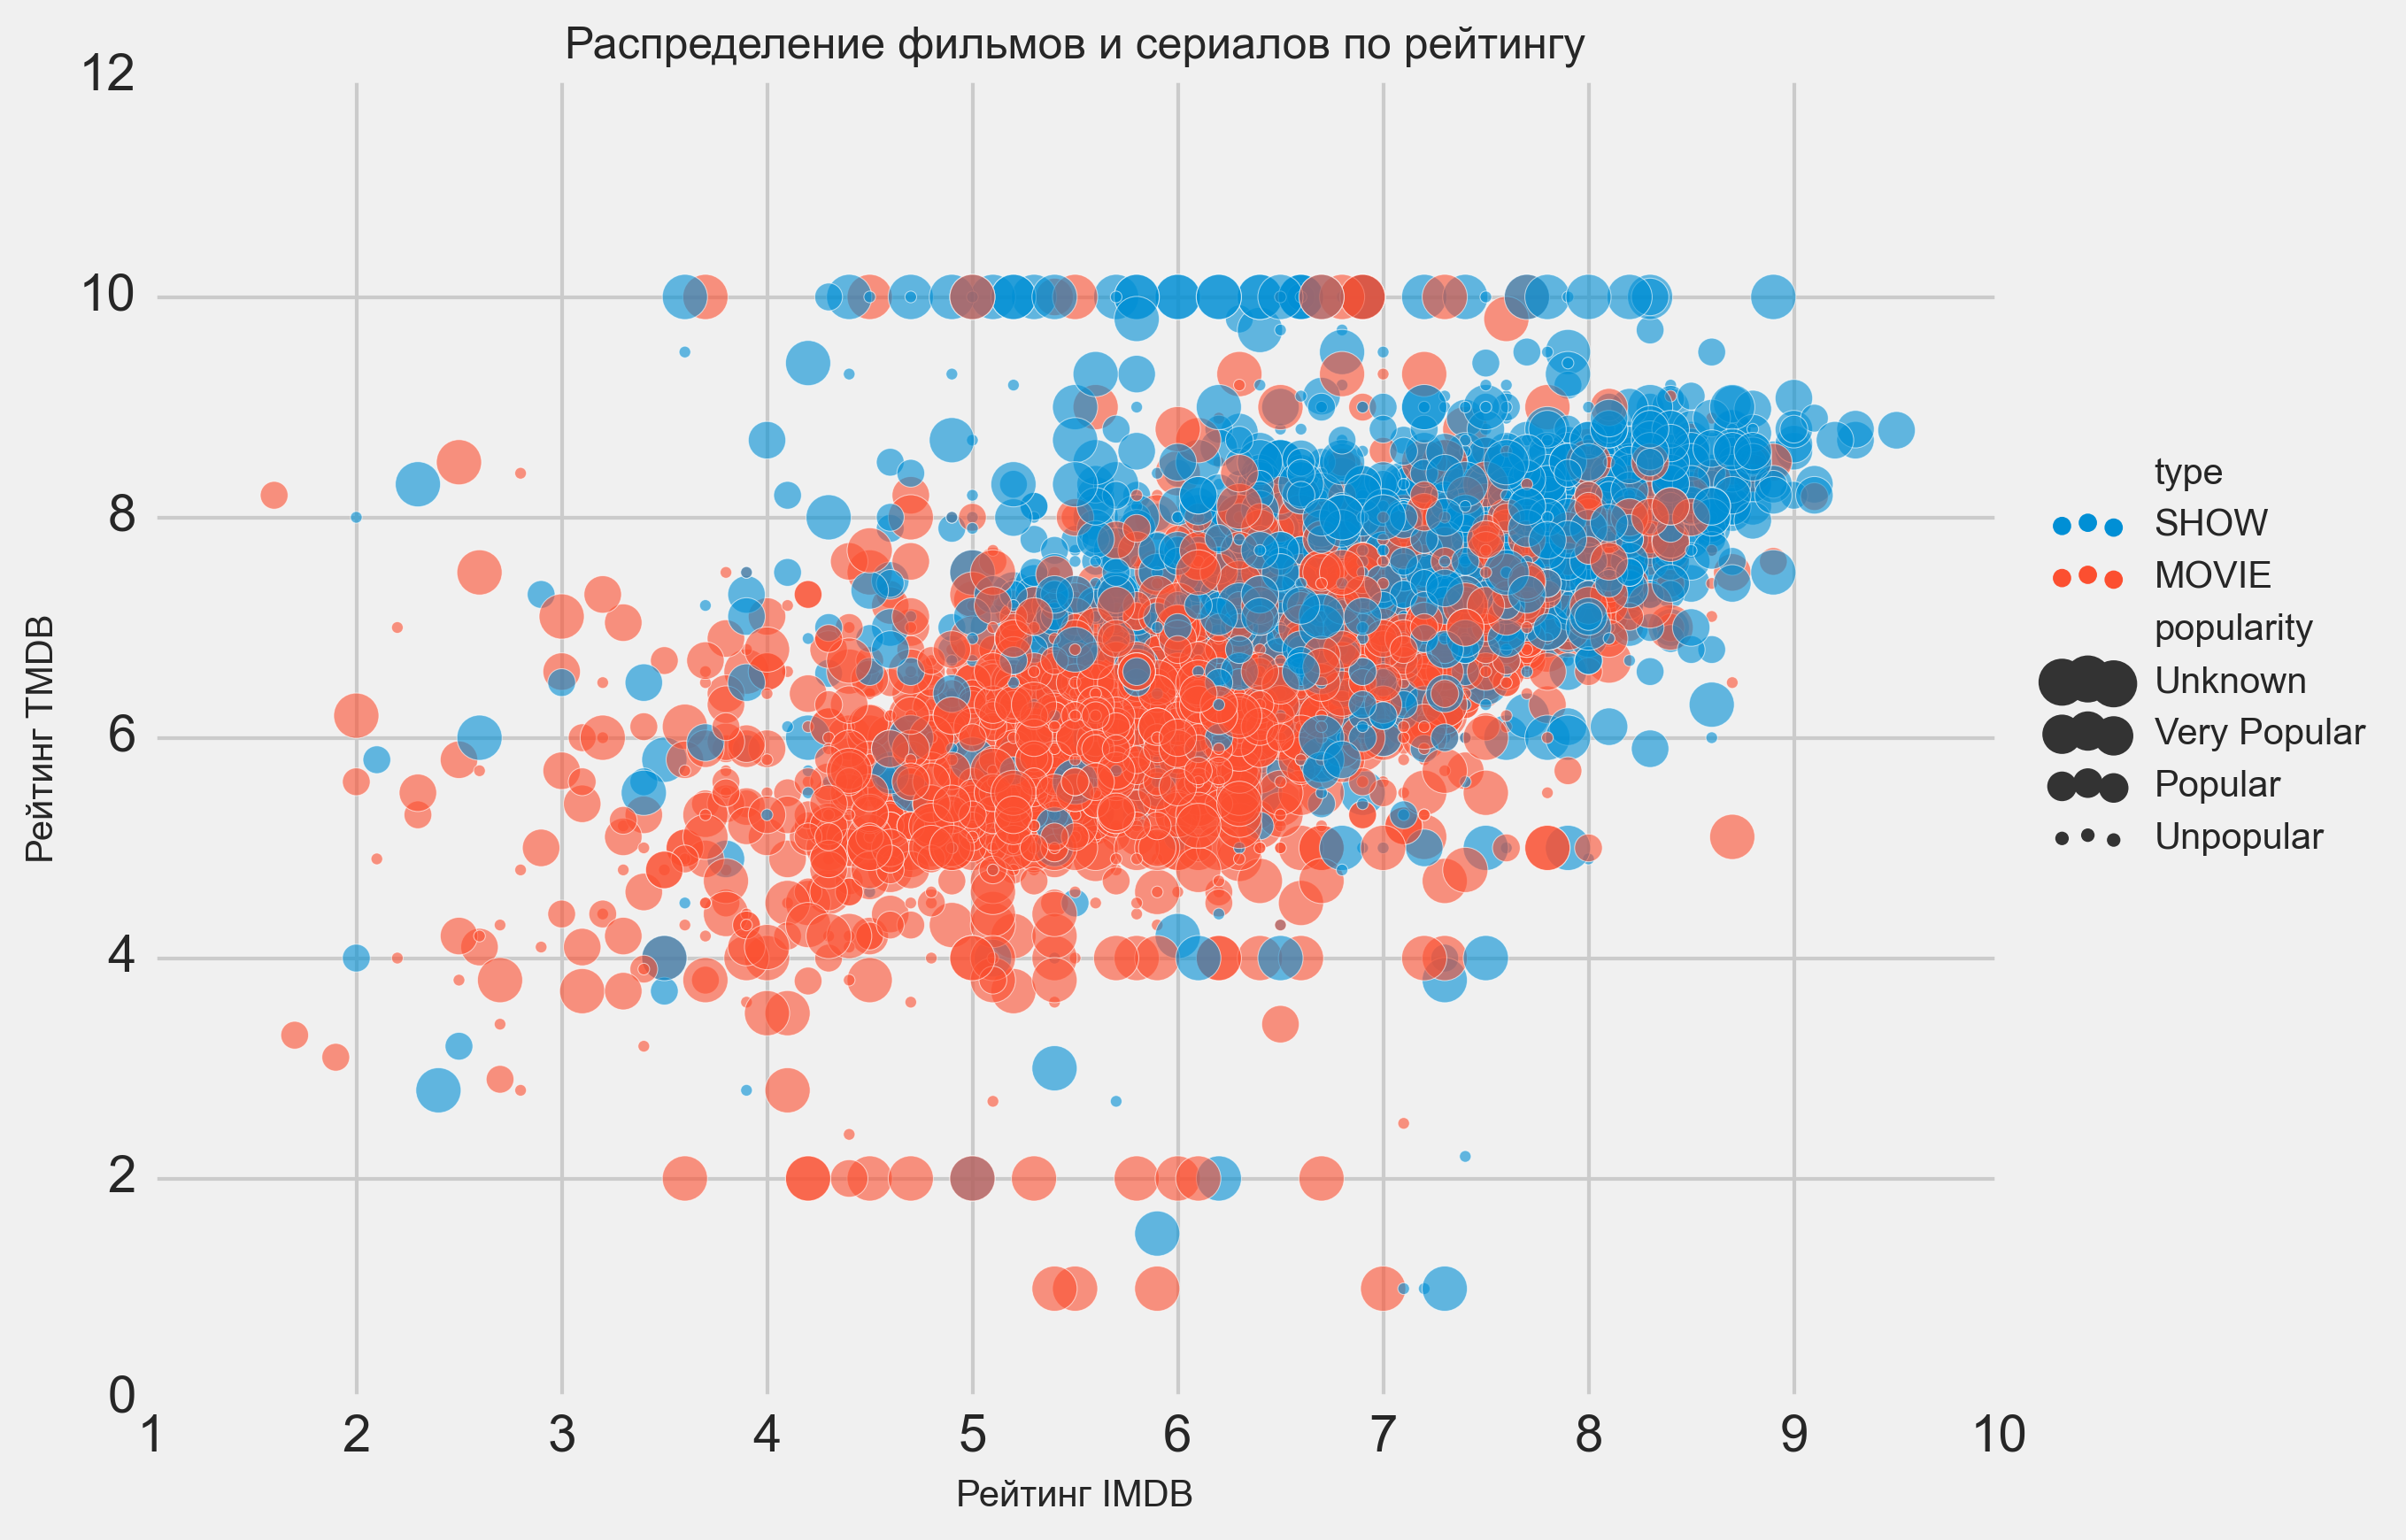

In [88]:
plt.figure(figsize=(8,6),dpi=300)
plt.style.use('fivethirtyeight')
sns.scatterplot(data=df,x='imdb_score',y='tmdb_score',hue='type', size='popularity', sizes=(10, 150), alpha=0.6)
plt.xlabel("Рейтинг IMDB", size=10)
plt.ylabel("Рейтинг TMDB", size=10)
plt.title("Распределение фильмов и сериалов по рейтингу", size=12)
plt.legend(loc=(1.02,0.4), prop={'size': 10})

In [59]:
df.head()

,netflix_id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,american,ratings,popularity
2658,ts265844,#ABtalks,SHOW,#ABtalks is a YouTube interview show hosted by...,2018,PG,68.0,unknown,unknown,1.0,tt12635254,9.6,7.0,NaN,NaN,US not involved,IMDB only,Unknown
3237,tm820190,#Alive,MOVIE,"As a grisly virus rampages a city, a lone man ...",2020,NaN,98.0,"horror, thriller, action, drama",KR,NaN,tt10620868,6.3,38313.0,58.967,7.3,US not involved,Both,Very Popular
4095,tm817087,#AnneFrank. Parallel Stories,MOVIE,One single Anne Frank moves us more than the c...,2019,NaN,92.0,"drama, history, documentation",IT,NaN,tt9850370,6.5,1548.0,8.190,7.1,US not involved,Both,Popular
2875,tm371188,#FriendButMarried,MOVIE,"Pining for his high school crush for years, a ...",2018,NaN,102.0,"romance, comedy, drama",ID,NaN,tt8076266,6.8,714.0,1.257,6.7,US not involved,Both,Unpopular
4549,tm846354,#FriendButMarried 2,MOVIE,As Ayu and Ditto finally transition from best ...,2020,NaN,104.0,"drama, comedy, romance",ID,NaN,tt11640412,6.9,311.0,2.063,7.5,US not involved,Both,Unknown


In [64]:
df_country_genres_plot.head()


,unknown,horror,thriller,action,drama,history,documentation,romance,comedy,reality,fantasy,european,family,war,crime,sport,scifi,animation,music,western
production_countries,,,,,,,,,,,,,,,,,,,,
US,26.984127,40.133038,29.568106,32.137733,25.504691,30.357143,52.258065,21.584699,37.903861,54.356846,34.959350,14.449213,43.586550,28.017241,30.558097,42.553191,40.088757,35.906863,45.674740,58.928571
IN,1.587302,5.986696,12.425249,12.051650,13.534262,5.059524,1.751152,18.214936,10.165485,1.244813,4.065041,1.859800,4.483188,2.586207,13.815188,12.765957,1.331361,2.941176,4.152249,1.785714
GB,0.000000,4.878049,7.109635,4.949785,4.918965,13.690476,8.940092,3.642987,5.161545,6.639004,6.368564,11.587983,6.475716,15.086207,6.953339,5.851064,5.325444,5.514706,6.574394,7.142857
JP,4.761905,5.543237,3.654485,11.764706,4.805232,1.785714,1.013825,4.371585,3.743105,4.564315,15.176152,0.286123,4.732254,4.741379,2.378774,4.255319,16.863905,22.426471,4.844291,7.142857
FR,1.587302,3.325942,4.252492,3.299857,4.037532,5.357143,2.949309,3.096539,3.112687,1.659751,3.929539,16.165951,3.611457,5.172414,4.940531,2.659574,2.514793,4.289216,3.460208,3.571429


Text(0.5, 0, 'Year of Production')

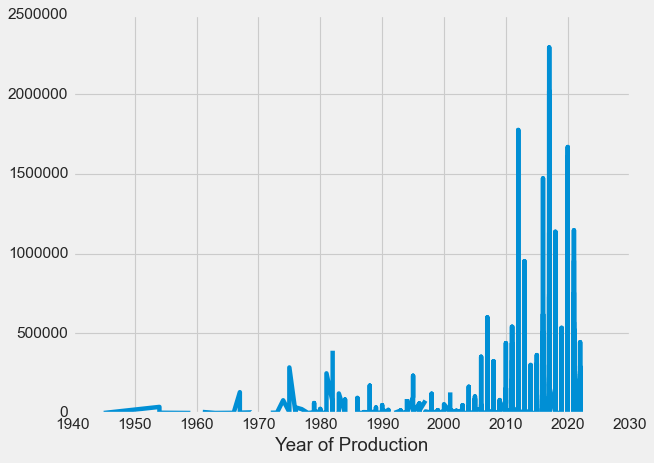

In [90]:
plt.plot(df['release_year'].sort_values(), df['imdb_votes'])
plt.ticklabel_format(axis = 'x', style='plain', useOffset=False)
plt.xlabel('Year of Production')